#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = len(y)
    z = y * (X @ w + w0)
    loss_value = (1 / N) * np.sum(np.log(1 + np.exp(-z))) + gamma * np.sum(np.abs(w)) + beta * np.sum(w ** 2)
    return loss_value

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[np.ndarray, float]:
    N = len(y)
    z = y * (X @ w + w0)

    grad_w = (-1 / N) * (X.T @ (y / (1 + np.exp(z)))) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = (-1 / N) * np.sum(y / (1 + np.exp(z)))

    return np.array(grad_w), grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        y = 2 * y - 1
        np.random.seed(self.random_state)
        self.w = np.zeros(X.shape[1])
        self.w0 = 0.0

        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)

            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0
            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(current_loss)

            if np.linalg.norm(grad_w) < self.tolerance:
                break
        return self

    def predict_proba(self, X):
        linear_comb = X @ self.w + self.w0
        probabilities = np.clip(1 / (1 + np.exp(-linear_comb)), 1e-15, 1 - 1e-15)
        return np.vstack([1 - probabilities, probabilities]).T

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= 0.5).astype(int)

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k', cmap="coolwarm")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

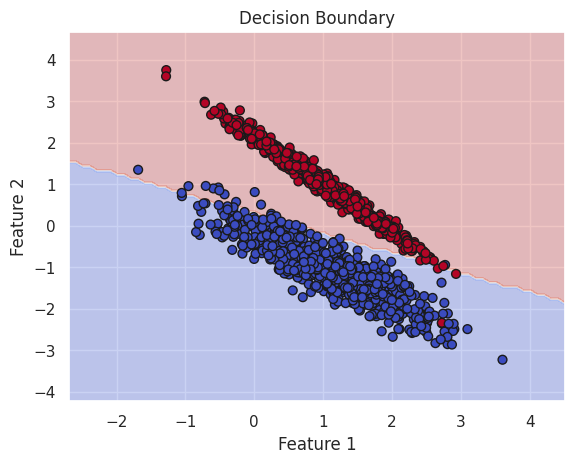

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history, marker='o')
    plt.title("Loss Function History")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

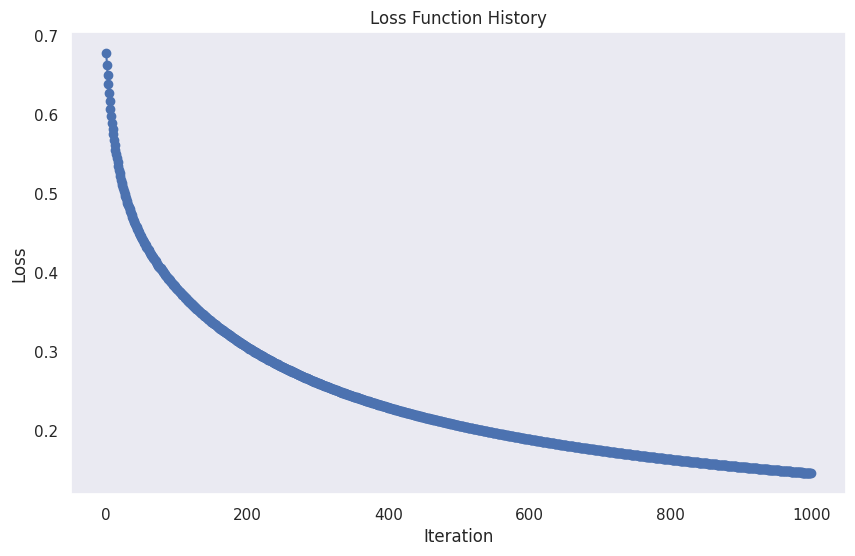

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]


for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True)
        model.fit(X_train, y_train)


        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]


        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)


        print(f"Kernel: {kernel}, C: {C}")
        print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC-ROC: {roc_auc:.4f}, F1-Score: {f1:.4f}")
        print("-" * 50)

Kernel: linear, C: 0.1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9998, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9994, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 10
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9988, F1-Score: 0.9971
--------------------------------------------------
Kernel: linear, C: 100
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9988, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 0.1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9963, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 1
Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9977, F1-Score: 0.9971
--------------------------------------------------
Kernel: poly, C: 10
Accuracy: 0.9972, Preci

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]


        predictions = []
        for labels in nearest_labels:
            unique, counts = np.unique(labels, return_counts=True)
            predicted_label = unique[np.argmax(counts)]
            predictions.append(predicted_label)

        return np.array(predictions)

    def predict_proba(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_labels = self.y_train[nearest_indices]


        probabilities = []
        for labels in nearest_labels:
            unique, counts = np.unique(labels, return_counts=True)
            prob = np.zeros(np.max(self.y_train) + 1)
            prob[unique] = counts / self.n_neighbors
            probabilities.append(prob)

        return np.array(probabilities)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score


X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


knn = KNNClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba[:, 1])
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC-ROC: {roc_auc:.4f}, F1-Score: {f1:.4f}")

Accuracy: 0.9972, Precision: 0.9943, Recall: 1.0000, AUC-ROC: 0.9973, F1-Score: 0.9971


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
data = pd.read_csv('train.csv')

print(data.head())


train_data = data[:50000]
test_data = data[50000:]


X_train = train_data.drop(columns=['Id', 'Category'])
y_train = train_data['Category']

X_test = test_data.drop(columns=['Id', 'Category'])
y_test = test_data['Category']


print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

   Id  Category  Pixel000  Pixel001  Pixel002  Pixel003  Pixel004  Pixel005  \
0   0         2         0         0         0         0         0         0   
1   1         9         0         0         0         0         0         0   
2   2         6         0         0         0         0         0         0   
3   3         0         0         0         0         1         2         0   
4   4         3         0         0         0         0         0         0   

   Pixel006  Pixel007  ...  Pixel774  Pixel775  Pixel776  Pixel777  Pixel778  \
0         0         0  ...         0         0         0         0         0   
1         0         0  ...         0         0         0         0         0   
2         0         5  ...         0         0         0        30        43   
3         0         0  ...         3         0         0         0         0   
4         0         0  ...         0         0         0         0         0   

   Pixel779  Pixel780  Pixel781  Pixel782  P

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

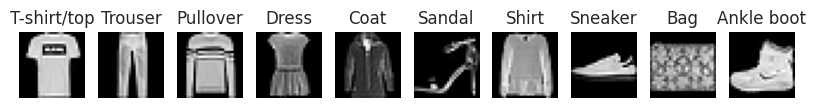

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
images = fashion_mnist.data.values.reshape(-1, 28, 28)
labels = fashion_mnist.target.astype(int)


class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


plt.figure(figsize=(10, 10))
for i in range(10):

    plt.subplot(1, 10, i + 1)
    plt.imshow(images[labels == i][0], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
images = fashion_mnist.data.values.reshape(-1, 28, 28)
labels = fashion_mnist.target.astype(int)


images_reshaped = images.reshape(-1, 28 * 28)


standard_scaler = StandardScaler()
images_standard_scaled = standard_scaler.fit_transform(images_reshaped)


minmax_scaler = MinMaxScaler()
images_minmax_scaled = minmax_scaler.fit_transform(images_reshaped)


print("Statistics after StandardScaler:")
print("Minimum:", np.min(images_standard_scaled), "Maximum:", np.max(images_standard_scaled))
print("Statistics after MinMaxScaler:")
print("Minimum:", np.min(images_minmax_scaled), "Maximum:", np.max(images_minmax_scaled))

Statistics after StandardScaler:
Minimum: -2.4115701151932663 Maximum: 194.09155051552787
Statistics after MinMaxScaler:
Minimum: 0.0 Maximum: 1.0


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn_params = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
logreg_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}


knn = KNeighborsClassifier()
logreg = LogisticRegression()


knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy')
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy')


knn_grid.fit(X_train, y_train)
logreg_grid.fit(X_train_scaled, y_train)


knn_best_params = knn_grid.best_params_
knn_best_score = knn_grid.best_score_
logreg_best_params = logreg_grid.best_params_
logreg_best_score = logreg_grid.best_score_


knn_best = KNeighborsClassifier(**knn_best_params)
logreg_best = LogisticRegression(**logreg_best_params)
knn_best.fit(X_train, y_train)
logreg_best.fit(X_train_scaled, y_train)


y_pred_knn = knn_best.predict(X_test)
y_pred_logreg = logreg_best.predict(X_test_scaled)


knn_accuracy = accuracy_score(y_test, y_pred_knn)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

print("KNeighborsClassifier:")
print(f"Best parameters: {knn_best_params}")
print(f"Cross-validated accuracy on train: {knn_best_score:.4f}")
print(f"Test accuracy: {knn_accuracy:.4f}")

print("\nLogisticRegression:")
print(f"Best parameters: {logreg_best_params}")
print(f"Cross-validated accuracy on train: {logreg_best_score:.4f}")
print(f"Test accuracy: {logreg_accuracy:.4f}")

if knn_accuracy > logreg_accuracy:
    print("\nKNeighborsClassifier shows better accuracy.")
elif knn_accuracy < logreg_accuracy:
    print("\nLogisticRegression shows better accuracy.")
else:
    print("\nBoth models show the same accuracy.")

KNeighborsClassifier:
Best parameters: {'metric': 'euclidean', 'n_neighbors': 7}
Cross-validated accuracy on train: 0.9958
Test accuracy: 0.9972

LogisticRegression:
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-validated accuracy on train: 0.9958
Test accuracy: 0.9972

Both models show the same accuracy.


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.


При запуске логистической регрессии на датасете с 10,000 объектами, где все признаки одинаковые, но классы различаются (5000 объектов положительного класса и 5000 объектов отрицательного класса), модель не сможет корректно обучиться. В результате обучения будет получена следующая ситуация:

1. Отсутствие разделимости классов: Поскольку все объекты имеют одинаковые значения признаков, модель не сможет различить положительный и отрицательный классы.

2. Неопределенные веса: Обновления весов модели будут одинаковыми для всех объектов, что приведет к их неэффективному обучению. Модель не сможет выделить паттерны или провести разделяющую гиперплоскость.

3. Точность классификации: Итоговая точность классификации будет близка к 0.5, что соответствует случайному угадыванию, поскольку у модели нет информации для правильного прогнозирования.

Таким образом, результат обучения модели на таком датасете будет неэффективным, с плохой способностью к обобщению и высокой вероятностью ошибочных классификаций.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

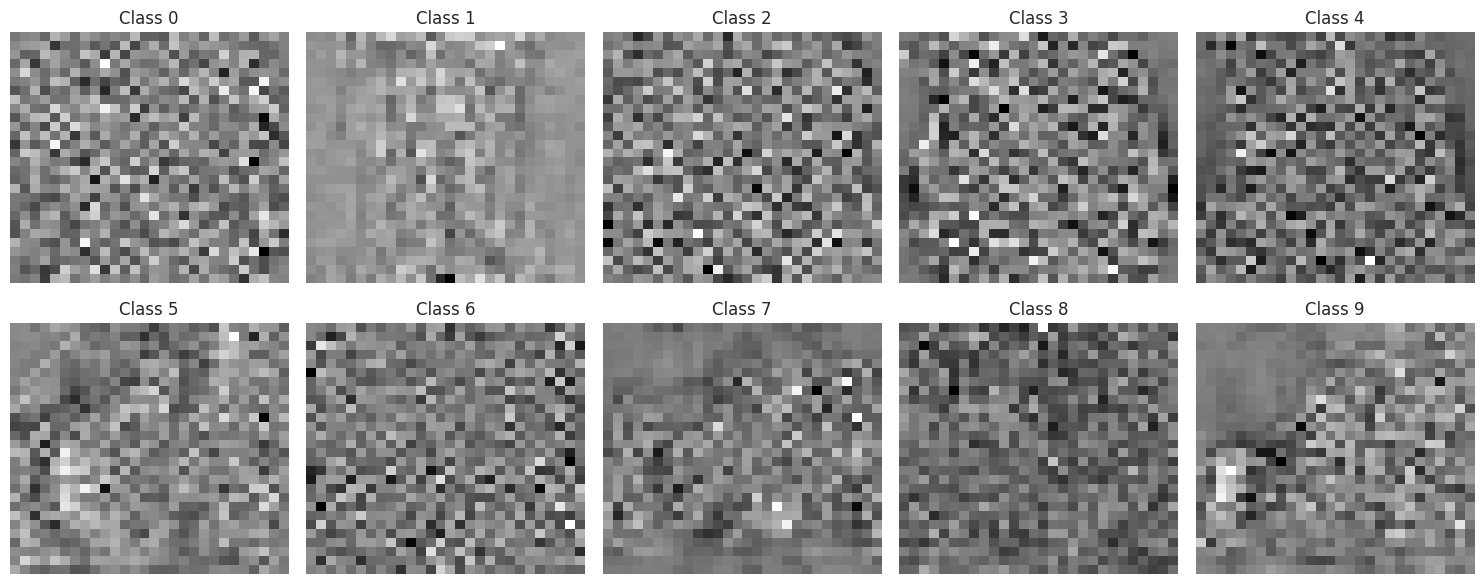

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier


fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X = fashion_mnist.data.values
y = fashion_mnist.target.astype(int)


X, _, y, _ = train_test_split(X, y, train_size=10000, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = OneVsRestClassifier(LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42))
model.fit(X_train_scaled, y_train)


weights = model.estimators_
n_classes = len(weights)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(n_classes):
    ax = axes[i]
    ax.imshow(weights[i].coef_.reshape(28, 28), cmap='gray', aspect='auto')
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Возможные графические паттерны
Выученные паттерны: Поскольку веса отображаются как изображения, можно заметить, что модель логистической регрессии может выучить некоторые графические паттерны, соответствующие различным классам одежды. Например, в весах для класса "сапоги" могут быть заметны элементы, напоминающие форму или текстуру обуви.

Обоснование:
Линейная модель: Логистическая регрессия — это линейная модель, которая пытается найти линейную границу между классами. Она делает это путем вычисления весов для каждого признака (пикселя) в изображении.

Графические паттерны: Поскольку веса соответствуют каждому пикселю, визуализация коэффициентов позволяет увидеть, какие пиксели (или группы пикселей) наиболее важны для классификации каждого класса. Если модель выучила определенные паттерны, это может свидетельствовать о том, что она обнаружила уникальные характеристики, отличающие один класс от другого.

Требования к данным: Успех модели также зависит от качества данных. Если в данных присутствуют классы, четко отличающиеся друг от друга, модель будет лучше определять паттерны, чем в случае пересекающихся классов.

Важно помнить, что это просто визуальное сходство. Логистическая регрессия не выучила точные фигуры, а скорее выделила области в изображении, которые наиболее важны для классификации.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

data = pd.read_csv('train.csv')
X = data.drop(columns=['Id', 'Category']).values
y = data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
gb_best = gb_grid.best_estimator_

voting_clf = VotingClassifier(
    estimators=[('rf', rf_best), ('gb', gb_best)],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)

ensemble_accuracy = accuracy_score(y_test, voting_clf.predict(X_test_scaled))

print("RandomForestClassifier:")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Test accuracy: {accuracy_score(y_test, rf_best.predict(X_test_scaled)):.4f}")

print("\nGradientBoostingClassifier:")
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Test accuracy: {accuracy_score(y_test, gb_best.predict(X_test_scaled)):.4f}")

print("\nVotingClassifier (Ensemble):")
print(f"Test accuracy: {ensemble_accuracy:.4f}")

if ensemble_accuracy > 0.87:
    print("\nAchieved accuracy > 0.87 with ensemble model.")
else:
    print("\nDid not achieve required accuracy with the ensemble model.")

KeyboardInterrupt: 